# Absorbing Boundaries

To solve the differential equation problems involved in SeisCL modelisation, we obviously need to set boundary conditions. Dirichelet boundary condition can't be used effectively in numerical simulation since it causes artificials reflections. To minimise those reflections, SeisCL can use two types of absorbings boundaries : the convolutional perfectly matched layer (CPML) [Komatitsch and Martin (2007)](https://doi.org/10.1190/1.2757586) and the dissipative layer of [Cerjan, et al., 1985](https://doi.org/10.1190/1.1441945).

## Theory

### 1. Cerjan

Cerjan et Al. have described a simple absorbing boundary layer in which the numerical grid is enlarged by a few grid points (typically 30 grid points) in each direction. The values of the stress and particle velocity in this boundary frame are multiplied by a factor "damp" : 

$$ \textrm{damp} = e^{-a^2 x^2}$$

with $ a = \sqrt{{-\log(\textrm{amp})}/{\textrm{nab}}} $, $\textrm{amp} = 1 - \textrm{abpc}/100$. Variables $x$ is the distance from the boundary, $\textrm{nab}$ is the width of the absorbing boundary and $\textrm{nab}$ is the absorption percentage. The seismic waves are damped inside the boundary frame and cannot be reflected back into the model.
However, with Cerjan's simple formulation, the wavefield is still partialy reflected at the boundary between the absorbent layer and the model.

<br>

### 2. CPML

The perfectly matched layer distinguishes itself from an ordinary absorbing material by being designed so that waves incident upon the PML from a non-PML medium do not reflect at the interface. This property allows the PML to strongly absorb outgoing waves from the interior of a computational region without reflecting them back into the interior.

First derived by [Berenger](https://doi.org/10.1006/jcph.1994.1159), the idea behind PML is to use a coordinate transformation into complex coordinates replacing propagating (oscillating) waves by exponentially decaying waves. In SeisCL, [Komatitsch](https://doi.org/10.1046/j.1365-246X.2003.01950.x) formulation is used where :

$$ \tilde{x}\,(x) = x - \frac{i}{\omega} \int_{0}^{x} d_x(s) \, ds  \qquad \rightarrow  \qquad \tilde{\partial_{x}}=\frac{\mathrm{i} \omega}{\mathrm{i} \omega+d_{x}} \partial_{x} $$


where $\omega$  is the angular frequency and $d_x(s)$ is a damping profile in x. Wherever $d_x(s)$ is positive, propagating waves are attenuated because:

<br>

$$ \normalsize e^{-i(\mathbf{k} \tilde{x} - \omega t)} \qquad \rightarrow \qquad  e^{-\mathbf{i}(\mathbf{k} \cdot \mathbf{x}-\omega t)} e^{-k_{x} / \omega \int_{0}^{x} d_{x}(s) \mathrm{d} s} $$

<br>


<!-- Let us note that this damping coefficient depends on the direction of propagation of the wave, and is large for a wave propagating close to normal incidence, but becomes significantly smaller for a wave propagating at grazing incidence,
which explains the reduced efficiency of the classical PML model at grazing incidence. Let us also note that the reflection coefficient between the medium and the PML region is exactly zero for all angles of incidence and all frequencies here, before discretization by a numerical scheme, hence the name perfectly matched layer. -->


In the PML formulation, the damping coefficient depends on the direction of propagation of the wave, and is large for a wave propagating close to normal incidence, but becomes significantly smaller for a wave propagating at grazing incidence. It is always important to note that PML is only reflectionless for the exact wave equation and once discretized, some numerical reflections appear. With increasing resolution, those gradually vanish.

## Boundaries interactions with sources and receivers

Note that sources and receivers coordinates take the left corner of the grid as a reference. Hence, when using an absorbing layer, the first grid points are located inside the absorbing layer. 

<br>
It is therefore important to set the position of both of them on the outside of the layer. It's also a good pratice to add a small buffer to remove any interference the PML could have on the result. Here the buffer is twice the size of the order of the finite difference.

As usual we import the relevant modules and we define the basic constants.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seis = SeisCL()

In [2]:
seis.ND = 2
seis.N = np.array([250, 500])
seis.dt = dt = 0.25e-03
seis.dh = dh = 2
seis.NT = NT = 1500
seis.FDORDER = 4
seis.seisout = 2

The thickness of the absorbing layer is set with `nab`. We first define it as 16 grid points. On GPU, a good practice if to set `nab` to a multiple of 16.

In [3]:
Nz = seis.N[0]
Nx = seis.N[1]

seis.nab = nab = 8
nbuf = seis.FDORDER * 2

sx = (2*nab + nbuf) * dh
sy = 0
sz = (2*nab + nbuf) * dh
offmin = 20 * dh
offmax = (Nx - 4*nab - nbuf) * dh - offmin
gx = np.arange(sx + offmin, sx + offmax, 8*dh)
gy = gx * 0
gz = gx * 0 + (2*nab + nbuf) * dh
offset = gx-sx

seis.src_pos_all = np.stack([[sx], [sy], [sz], [0], [100]], axis=0)

gsid = gz * 0
gid = np.arange(0, len(gz))
seis.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)

Let's define a two-layer model

In [4]:
vp = [3500, 2000]
vs = 2000
rho = 2000

vp_all = np.zeros(seis.N) + vp[0]
vp_all[seis.N[0]//2:, :] = vp[1]
vs_all = np.zeros(seis.N) + vs
rho_all = np.zeros(seis.N) + rho

model = {"vp": vp_all, "rho": rho_all, "vs": vs_all}

Now we can visualize the geometry, source, receivers and boundary layers to make sure that no interference will take place.

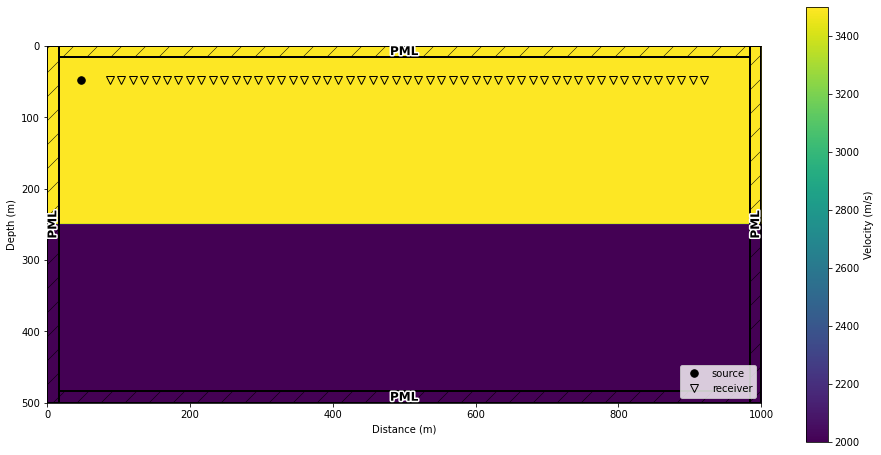

In [5]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seis.DrawDomain2D(vp_all, ax = ax, showabs = True, showsrcrec = True)

## Comparison between Cerjan layer and CPML 

Let's compare the different absorbing layers in `SeisCL`. The parameter `abs_type = 1` uses CPML, `abs_type = 2` uses Cerjan sponge layer and  `abs_type = 0` uses no absorbing layer.

Let's first start with the CPML. Several variables control the behavior of the CPML. The most relevant are:

* VPPML: Set it to the Vp velocity near CPML boundary
* FPML: Set it to the dominant frequency of the wavefield

In [6]:
seis.abs_type = 1
seis.VPPML = vp[0]
seis.FPML = seis.f0
seis.set_forward(gsid, model, withgrad=False)
InfoPML = seis.execute()
dataPML = seis.read_data()[0]

Cerjan absorbing layer is simpler, and only the parameter `abpc` that controls the exponential amplitude decay must be set.

In [7]:
seis.abs_type = 2
seis.abpc = 4
seis.set_forward(gsid, model, withgrad=False)
InfoCerjan = seis.execute()
dataCerjan = seis.read_data()[0]

Finally, we can turn off the absorbing layer altogther.

In [8]:
seis.abs_type = 0
seis.set_forward(gsid, model, withgrad=False)
InfoCerjan = seis.execute()
datanoabs = seis.read_data()[0]

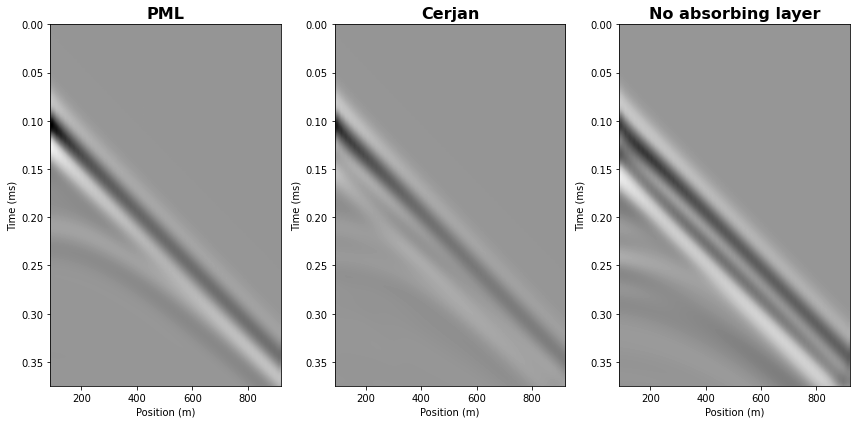

In [9]:
def plot_seis(seis1, seis2, seis3):
    _, ax = plt.subplots(1, 3, figsize=[12, 6])
    extent = [min(gx), max(gx), (dataPML.shape[0]-1)*dt, 0]
    clip = 1
    vmax = np.max(dataPML) * clip
    vmin = -vmax
    ax[0].imshow(dataPML, aspect='auto', vmax=vmax, vmin=vmin,
                 extent=extent, interpolation='bilinear',
                 cmap=plt.get_cmap('Greys'))
    ax[0].set_title("PML", fontsize=16, fontweight='bold')
    ax[0].set_xlabel("Position (m)")
    ax[0].set_ylabel("Time (ms)")

    ax[1].imshow(dataCerjan, aspect='auto', vmax=vmax, vmin=vmin,
                 extent=extent, interpolation='bilinear',
                 cmap=plt.get_cmap('Greys'))
    ax[1].set_title("Cerjan", fontsize=16, fontweight='bold')
    ax[1].set_xlabel("Position (m)")
    ax[1].set_ylabel("Time (ms)")

    ax[2].imshow(datanoabs, aspect='auto', vmax=vmax, vmin=vmin,
                 extent=extent, interpolation='bilinear',
                 cmap=plt.get_cmap('Greys'))
    ax[2].set_title("No absorbing layer", fontsize=16, fontweight='bold')
    ax[2].set_xlabel("Position (m)")
    ax[2].set_ylabel("Time (ms)")

    plt.tight_layout()
    plt.show()
plot_seis(dataPML, dataCerjan, datanoabs)

As we can see, the CPML is the most effective method to reduce artificial reflections.

We can double de width of the aborbing layer and see if we can improve the results

In [10]:
seis.nab = 16
seis.abs_type = 1
seis.set_forward(gsid, model, withgrad=False)
InfoPML = seis.execute()
dataPML = seis.read_data()[0]

seis.abs_type = 2
seis.set_forward(gsid, model, withgrad=False)
InfoCerjan = seis.execute()
dataCerjan = seis.read_data()[0]

seis.abs_type = 0
seis.set_forward(gsid, model, withgrad=False)
InfoCerjan = seis.execute()
datanoabs = seis.read_data()[0]

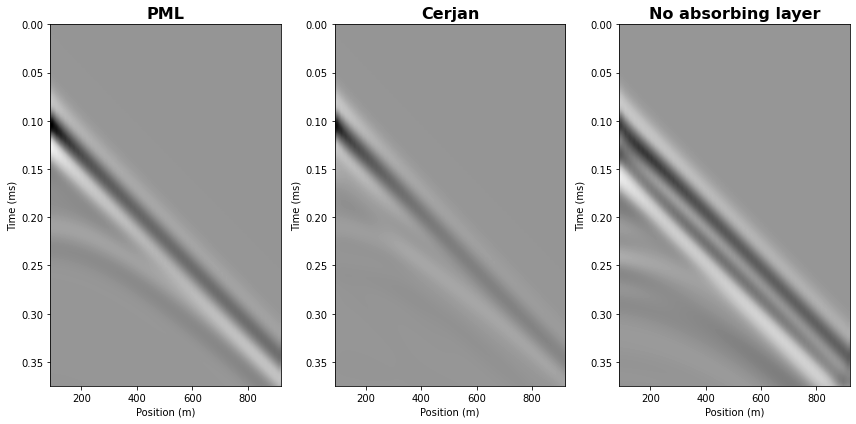

In [11]:
plot_seis(dataPML, dataCerjan, datanoabs)

Usually, Cerjan absorbing layer needs much larger width to be effective than the CPML. It is however sometimes more stable than the CPML.